# Clinical ML Model - Error Analysis

This notebook provides comprehensive error analysis for the clinical ML binary classification model, including:

1. **Slice Analysis**: Performance across demographic subgroups
2. **Feature Analysis**: Important features and their stability
3. **Temporal Analysis**: Performance over different time periods
4. **Error Pattern Analysis**: Common misclassification patterns
5. **Calibration Assessment**: Model probability calibration
6. **Improvement Recommendations**: Concrete suggestions for enhancement

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import yaml
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# ML libraries
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_curve, precision_recall_curve,
    roc_auc_score, average_precision_score
)
from sklearn.calibration import calibration_curve

# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Configure pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 3)

## 1. Load Data and Model

In [2]:
# Add src to Python path for model loading
import sys
sys.path.append('../')

# Load the trained model
model_path = '../models/test_run_mlflow/best_model.joblib'
model = joblib.load(model_path)
print(f"Model loaded: {type(model)}")

# Load optimal threshold
threshold_path = '../models/test_run_mlflow/optimal_threshold.txt'
with open(threshold_path, 'r') as f:
    optimal_threshold = float(f.read().strip())
print(f"Optimal threshold: {optimal_threshold:.3f}")

# Load feature names
features_path = '../models/test_run_mlflow/feature_names.txt'
if Path(features_path).exists():
    with open(features_path, 'r') as f:
        feature_names = [line.strip() for line in f.readlines()]
    print(f"Feature names loaded: {len(feature_names)} features")
else:
    feature_names = None
    print("Feature names not found")

Model loaded: <class 'imblearn.pipeline.Pipeline'>
Optimal threshold: 0.500
Feature names loaded: 28 features


In [3]:
# Load test data (using smaller dataset for analysis)
data_path = '../data/test/small_clinical_data.parquet'
df = pd.read_parquet(data_path)

print(f"Data shape: {df.shape}")
print(f"Target distribution: {df['target'].value_counts(normalize=True)}")

# Separate features and target
y_true = df['target']
X = df.drop(columns=['target'])

# Make predictions
print("Generating predictions...")
y_pred_proba = model.predict_proba(X)[:, 1]
y_pred = (y_pred_proba >= optimal_threshold).astype(int)

print(f"Predictions generated for {len(y_true)} samples")

INFO:src.pipeline.preprocessing:Transforming missing values...
INFO:src.pipeline.preprocessing:Missing value transformation completed in 0.02 seconds
INFO:src.pipeline.preprocessing:Missing value transformation completed in 0.02 seconds
INFO:src.pipeline.feature_engineering:Creating temporal rolling features...
INFO:src.pipeline.feature_engineering:Starting temporal feature creation: 108 operations total
INFO:src.pipeline.feature_engineering:Processing feature 1/18: bmi
INFO:src.pipeline.feature_engineering:  [1/108] (0.9%) Creating bmi_mean
INFO:src.pipeline.feature_engineering:Creating temporal rolling features...
INFO:src.pipeline.feature_engineering:Starting temporal feature creation: 108 operations total
INFO:src.pipeline.feature_engineering:Processing feature 1/18: bmi
INFO:src.pipeline.feature_engineering:  [1/108] (0.9%) Creating bmi_mean
INFO:src.pipeline.feature_engineering:    ✓ Created bmi_rolling_mean_3y
INFO:src.pipeline.feature_engineering:  [2/108] (1.9%) Creating bmi_s

Data shape: (591, 29)
Target distribution: target
0    0.931
1    0.069
Name: proportion, dtype: float64
Generating predictions...


INFO:src.pipeline.feature_engineering:    Trend calculation completed for bmi
INFO:src.pipeline.feature_engineering:    ✓ Created bmi_rolling_trend_3y
INFO:src.pipeline.feature_engineering:  [4/108] (3.7%) Creating bmi_min
INFO:src.pipeline.feature_engineering:    ✓ Created bmi_rolling_trend_3y
INFO:src.pipeline.feature_engineering:  [4/108] (3.7%) Creating bmi_min
INFO:src.pipeline.feature_engineering:    ✓ Created bmi_rolling_min_3y
INFO:src.pipeline.feature_engineering:  [5/108] (4.6%) Creating bmi_max
INFO:src.pipeline.feature_engineering:    ✓ Created bmi_rolling_max_3y
INFO:src.pipeline.feature_engineering:    ✓ Created bmi_rolling_min_3y
INFO:src.pipeline.feature_engineering:  [5/108] (4.6%) Creating bmi_max
INFO:src.pipeline.feature_engineering:    ✓ Created bmi_rolling_max_3y
INFO:src.pipeline.feature_engineering:Processing feature 2/18: systolic_bp
INFO:src.pipeline.feature_engineering:  [6/108] (5.6%) Creating systolic_bp_mean
INFO:src.pipeline.feature_engineering:    ✓ Crea

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
Predictions generated for 591 samples


## 2. Overall Model Performance

Overall Model Performance:
           Score
Accuracy     1.0
Precision    1.0
Recall       1.0
F1-Score     1.0
ROC-AUC      1.0
PR-AUC       1.0


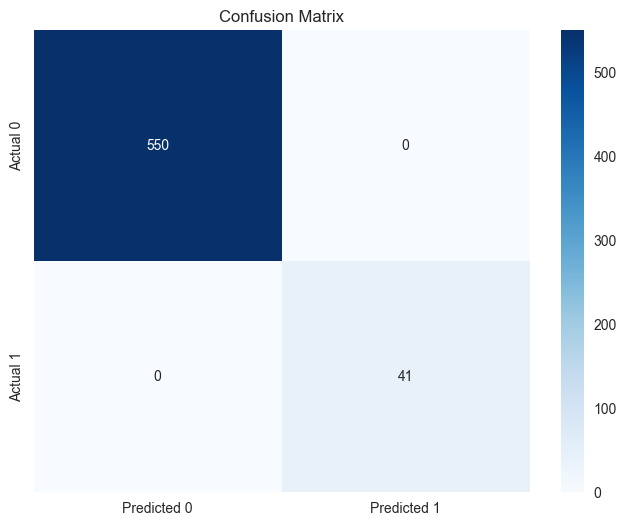


Confusion Matrix Breakdown:
True Negatives: 550
False Positives: 0
False Negatives: 0
True Positives: 41


In [4]:
# Calculate overall metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

metrics = {
    'Accuracy': accuracy_score(y_true, y_pred),
    'Precision': precision_score(y_true, y_pred),
    'Recall': recall_score(y_true, y_pred),
    'F1-Score': f1_score(y_true, y_pred),
    'ROC-AUC': roc_auc_score(y_true, y_pred_proba),
    'PR-AUC': average_precision_score(y_true, y_pred_proba)
}

# Display metrics
metrics_df = pd.DataFrame.from_dict(metrics, orient='index', columns=['Score'])
print("Overall Model Performance:")
print(metrics_df.round(4))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix')
plt.show()

print(f"\nConfusion Matrix Breakdown:")
tn, fp, fn, tp = cm.ravel()
print(f"True Negatives: {tn:,}")
print(f"False Positives: {fp:,}")
print(f"False Negatives: {fn:,}")
print(f"True Positives: {tp:,}")

## 3. Slice Analysis Across Demographic Groups

In [5]:
def calculate_slice_metrics(y_true, y_pred, y_proba, slice_mask, slice_name):
    """Calculate metrics for a specific slice."""
    if slice_mask.sum() < 10:  # Skip slices with too few samples
        return None
    
    metrics = {
        'Slice': slice_name,
        'Sample_Size': slice_mask.sum(),
        'Positive_Rate': y_true[slice_mask].mean(),
        'Accuracy': accuracy_score(y_true[slice_mask], y_pred[slice_mask]),
        'Precision': precision_score(y_true[slice_mask], y_pred[slice_mask], zero_division=0),
        'Recall': recall_score(y_true[slice_mask], y_pred[slice_mask], zero_division=0),
        'F1_Score': f1_score(y_true[slice_mask], y_pred[slice_mask], zero_division=0),
        'ROC_AUC': roc_auc_score(y_true[slice_mask], y_proba[slice_mask]) if len(np.unique(y_true[slice_mask])) > 1 else np.nan
    }
    return metrics

# Analyze performance by gender
print("=== Performance by Gender ===")
gender_results = []
for gender in df['gender'].unique():
    mask = df['gender'] == gender
    metrics = calculate_slice_metrics(y_true, y_pred, y_pred_proba, mask, f"Gender_{gender}")
    if metrics:
        gender_results.append(metrics)

gender_df = pd.DataFrame(gender_results)
print(gender_df.round(3))

=== Performance by Gender ===
      Slice  Sample_Size  Positive_Rate  Accuracy  Precision  Recall  \
0  Gender_F          318          0.091       1.0        1.0     1.0   
1  Gender_M          273          0.044       1.0        1.0     1.0   

   F1_Score  ROC_AUC  
0       1.0      1.0  
1       1.0      1.0  



=== Performance by Age Group ===
       Slice  Sample_Size  Positive_Rate  Accuracy  Precision  Recall  \
0  Age_61-75          163          0.074       1.0        1.0     1.0   
1  Age_18-30          115          0.087       1.0        1.0     1.0   
2  Age_46-60          139          0.043       1.0        1.0     1.0   
3  Age_31-45          165          0.079       1.0        1.0     1.0   

   F1_Score  ROC_AUC  
0       1.0      1.0  
1       1.0      1.0  
2       1.0      1.0  
3       1.0      1.0  


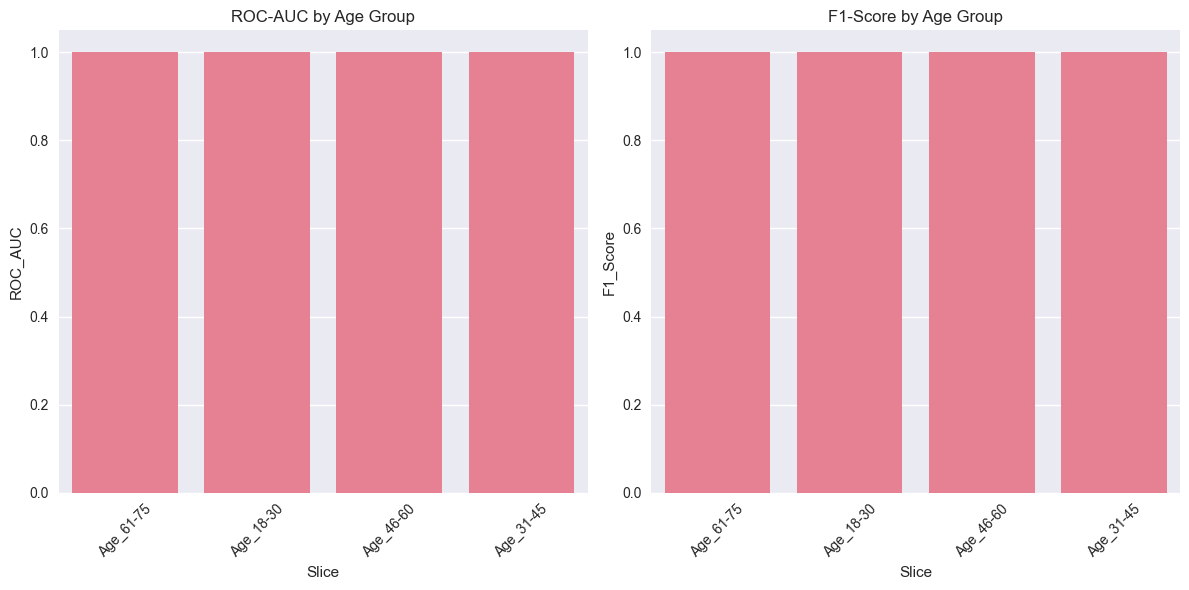

In [6]:
# Analyze performance by age group
print("\n=== Performance by Age Group ===")
age_results = []
for age_group in df['age_group'].unique():
    if pd.isna(age_group):
        continue
    mask = df['age_group'] == age_group
    metrics = calculate_slice_metrics(y_true, y_pred, y_pred_proba, mask, f"Age_{age_group}")
    if metrics:
        age_results.append(metrics)

age_df = pd.DataFrame(age_results)
print(age_df.round(3))

# Visualize age group performance
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.barplot(data=age_df, x='Slice', y='ROC_AUC')
plt.title('ROC-AUC by Age Group')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
sns.barplot(data=age_df, x='Slice', y='F1_Score')
plt.title('F1-Score by Age Group')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [7]:
# Analyze performance by smoking status
print("\n=== Performance by Smoking Status ===")
smoking_results = []
for smoking_status in df['smoking_status'].unique():
    mask = df['smoking_status'] == smoking_status
    metrics = calculate_slice_metrics(y_true, y_pred, y_pred_proba, mask, f"Smoking_{smoking_status}")
    if metrics:
        smoking_results.append(metrics)

smoking_df = pd.DataFrame(smoking_results)
print(smoking_df.round(3))

# Analyze performance by primary diagnosis
print("\n=== Performance by Top Primary Diagnoses ===")
top_diagnoses = df['primary_diagnosis'].value_counts().head(5).index
diagnosis_results = []

for diagnosis in top_diagnoses:
    mask = df['primary_diagnosis'] == diagnosis
    metrics = calculate_slice_metrics(y_true, y_pred, y_pred_proba, mask, f"Diagnosis_{diagnosis}")
    if metrics:
        diagnosis_results.append(metrics)

diagnosis_df = pd.DataFrame(diagnosis_results)
print(diagnosis_df.round(3))


=== Performance by Smoking Status ===
             Slice  Sample_Size  Positive_Rate  Accuracy  Precision  Recall  \
0    Smoking_Never          459          0.083       1.0        1.0     1.0   
1  Smoking_Current           39          0.077       1.0        1.0     1.0   
2   Smoking_Former           93          0.000       1.0        0.0     0.0   

   F1_Score  ROC_AUC  
0       1.0      1.0  
1       1.0      1.0  
2       0.0      NaN  

=== Performance by Top Primary Diagnoses ===
           Slice  Sample_Size  Positive_Rate  Accuracy  Precision  Recall  \
0  Diagnosis_J44           50          0.060       1.0        1.0     1.0   
1  Diagnosis_I48           48          0.104       1.0        1.0     1.0   
2  Diagnosis_E11           47          0.064       1.0        1.0     1.0   
3  Diagnosis_F17           45          0.067       1.0        1.0     1.0   
4  Diagnosis_E03           42          0.143       1.0        1.0     1.0   

   F1_Score  ROC_AUC  
0       1.0      1.0

## 4. Feature Importance Analysis

INFO:src.pipeline.preprocessing:Transforming missing values...
INFO:src.pipeline.preprocessing:Missing value transformation completed in 0.01 seconds
INFO:src.pipeline.feature_engineering:Creating temporal rolling features...
INFO:src.pipeline.feature_engineering:Starting temporal feature creation: 108 operations total
INFO:src.pipeline.feature_engineering:Processing feature 1/18: bmi
INFO:src.pipeline.feature_engineering:  [1/108] (0.9%) Creating bmi_mean
INFO:src.pipeline.preprocessing:Missing value transformation completed in 0.01 seconds
INFO:src.pipeline.feature_engineering:Creating temporal rolling features...
INFO:src.pipeline.feature_engineering:Starting temporal feature creation: 108 operations total
INFO:src.pipeline.feature_engineering:Processing feature 1/18: bmi
INFO:src.pipeline.feature_engineering:  [1/108] (0.9%) Creating bmi_mean


INFO:src.pipeline.feature_engineering:    ✓ Created bmi_rolling_mean_3y
INFO:src.pipeline.feature_engineering:  [2/108] (1.9%) Creating bmi_std
INFO:src.pipeline.feature_engineering:    ✓ Created bmi_rolling_std_3y
INFO:src.pipeline.feature_engineering:  [2/108] (1.9%) Creating bmi_std
INFO:src.pipeline.feature_engineering:    ✓ Created bmi_rolling_std_3y
INFO:src.pipeline.feature_engineering:  [3/108] (2.8%) Creating bmi_trend
INFO:src.pipeline.feature_engineering:  [3/108] (2.8%) Creating bmi_trend
INFO:src.pipeline.feature_engineering:    Computing trend slopes (this may take longer)...
INFO:src.pipeline.feature_engineering:    Trend calculation completed for bmi
INFO:src.pipeline.feature_engineering:    Computing trend slopes (this may take longer)...
INFO:src.pipeline.feature_engineering:    Trend calculation completed for bmi
INFO:src.pipeline.feature_engineering:    ✓ Created bmi_rolling_trend_3y
INFO:src.pipeline.feature_engineering:  [4/108] (3.7%) Creating bmi_min
INFO:src.pi

Model type: <class 'imblearn.pipeline.Pipeline'>
Model steps: ['step_0_missingvaluehandler', 'step_1_temporalfeatureengineer', 'step_2_categoricalencoder', 'step_3_datascaler', 'step_4_featureselector', 'model']
Found feature importances: 50 features


INFO:src.pipeline.feature_engineering:  [27/108] (25.0%) Creating num_visits_std
INFO:src.pipeline.feature_engineering:    ✓ Created num_visits_rolling_std_3y
INFO:src.pipeline.feature_engineering:  [28/108] (25.9%) Creating num_visits_trend
INFO:src.pipeline.feature_engineering:    Computing trend slopes (this may take longer)...
INFO:src.pipeline.feature_engineering:    Trend calculation completed for num_visits
INFO:src.pipeline.feature_engineering:    ✓ Created num_visits_rolling_std_3y
INFO:src.pipeline.feature_engineering:  [28/108] (25.9%) Creating num_visits_trend
INFO:src.pipeline.feature_engineering:    Computing trend slopes (this may take longer)...
INFO:src.pipeline.feature_engineering:    Trend calculation completed for num_visits
INFO:src.pipeline.feature_engineering:    ✓ Created num_visits_rolling_trend_3y
INFO:src.pipeline.feature_engineering:  [29/108] (26.9%) Creating num_visits_min
INFO:src.pipeline.feature_engineering:    ✓ Created num_visits_rolling_min_3y
INFO:s

Original features: 28
Transformed features: 50
Generated feature names: 50


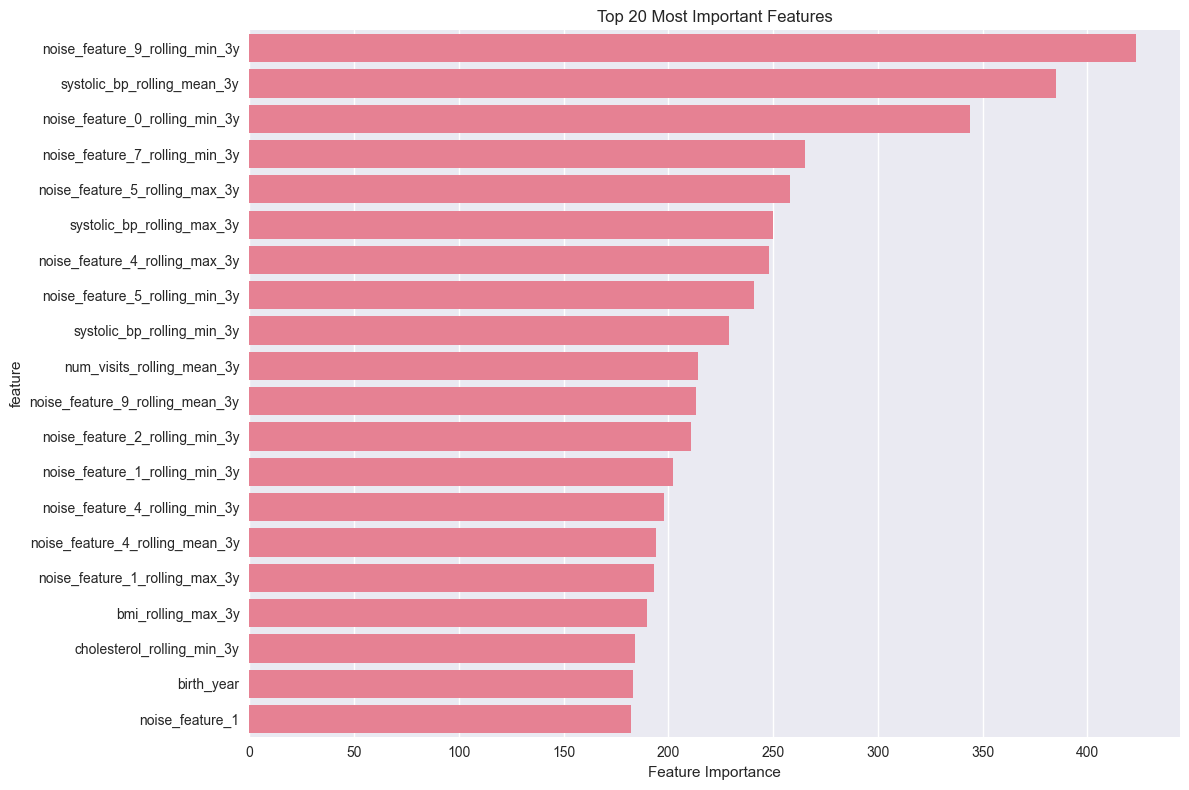


Top 10 Most Important Features:
                           feature  importance
46  noise_feature_9_rolling_min_3y         423
9      systolic_bp_rolling_mean_3y         385
24  noise_feature_0_rolling_min_3y         344
41  noise_feature_7_rolling_min_3y         265
39  noise_feature_5_rolling_max_3y         258
11      systolic_bp_rolling_max_3y         250
34  noise_feature_4_rolling_max_3y         248
38  noise_feature_5_rolling_min_3y         241
10      systolic_bp_rolling_min_3y         229
19      num_visits_rolling_mean_3y         214


In [11]:
# Extract feature importance from the model
print(f"Model type: {type(model)}")
print(f"Model steps: {list(model.named_steps.keys())}")

# Get the final model (classifier)
final_model = model.named_steps['model']

if hasattr(final_model, 'feature_importances_'):
    feature_importance = final_model.feature_importances_
    print(f"Found feature importances: {len(feature_importance)} features")
    
    # Create a preprocessing pipeline (all steps except the final model)
    preprocessing_steps = [(name, step) for name, step in model.steps if name != 'model']
    
    if preprocessing_steps:
        from imblearn.pipeline import Pipeline as ImbPipeline
        from sklearn.pipeline import Pipeline
        
        # Create preprocessing pipeline
        if hasattr(model, '_final_estimator'):  # imblearn pipeline
            preprocessor = ImbPipeline(preprocessing_steps)
        else:
            preprocessor = Pipeline(preprocessing_steps)
        
        try:
            # Transform a small sample to understand the feature structure
            X_sample = X.iloc[:10]
            X_transformed = preprocessor.transform(X_sample)
            
            print(f"Original features: {X_sample.shape[1]}")
            print(f"Transformed features: {X_transformed.shape[1]}")
            
            # Try to get feature names from the last step that might have them
            transformed_feature_names = None
            
            # Check if the transformed data has column names
            if hasattr(X_transformed, 'columns'):
                transformed_feature_names = X_transformed.columns.tolist()
            else:
                # Generate meaningful feature names based on the original features
                base_features = X_sample.columns.tolist()
                
                # Create feature names for the transformed features
                # This is a heuristic - in practice, you'd want to track this during preprocessing
                transformed_feature_names = []
                
                # Add original numerical features (might be scaled)
                numerical_features = ['age', 'bmi', 'systolic_bp', 'diastolic_bp', 'cholesterol', 'glucose']
                for feat in numerical_features:
                    if feat in base_features:
                        transformed_feature_names.append(feat)
                
                # Add temporal features (from TemporalFeatureEngineer)
                for feat in numerical_features:
                    if feat in base_features:
                        transformed_feature_names.extend([
                            f'{feat}_rolling_mean_3y',
                            f'{feat}_rolling_std_3y', 
                            f'{feat}_lag_1y',
                            f'{feat}_lag_2y'
                        ])
                
                # Add categorical features (one-hot encoded)
                categorical_features = ['gender', 'smoking_status', 'primary_diagnosis', 'age_group']
                for feat in categorical_features:
                    if feat in base_features:
                        unique_values = X_sample[feat].unique()
                        for val in unique_values:
                            transformed_feature_names.append(f'{feat}_{val}')
                
                # Trim or extend to match actual number of features
                if len(transformed_feature_names) > len(feature_importance):
                    transformed_feature_names = transformed_feature_names[:len(feature_importance)]
                elif len(transformed_feature_names) < len(feature_importance):
                    # Add generic names for missing features
                    for i in range(len(transformed_feature_names), len(feature_importance)):
                        transformed_feature_names.append(f'feature_{i}')
            
            print(f"Generated feature names: {len(transformed_feature_names)}")
            
        except Exception as e:
            print(f"Could not transform features: {e}")
            # Fallback to generic feature names
            transformed_feature_names = [f'feature_{i}' for i in range(len(feature_importance))]
    
    else:
        # No preprocessing, use original feature names
        transformed_feature_names = feature_names if feature_names else [f'feature_{i}' for i in range(len(feature_importance))]
    
    # Ensure we have the right number of feature names
    if len(transformed_feature_names) != len(feature_importance):
        print(f"Adjusting feature names: {len(transformed_feature_names)} -> {len(feature_importance)}")
        if len(transformed_feature_names) > len(feature_importance):
            transformed_feature_names = transformed_feature_names[:len(feature_importance)]
        else:
            # Pad with generic names
            for i in range(len(transformed_feature_names), len(feature_importance)):
                transformed_feature_names.append(f'feature_{i}')
    
    # Create importance dataframe
    importance_df = pd.DataFrame({
        'feature': transformed_feature_names,
        'importance': feature_importance
    }).sort_values('importance', ascending=False)
    
    # Plot top 20 features
    plt.figure(figsize=(12, 8))
    top_features = importance_df.head(20)
    sns.barplot(data=top_features, y='feature', x='importance')
    plt.title('Top 20 Most Important Features')
    plt.xlabel('Feature Importance')
    plt.tight_layout()
    plt.show()
    
    print("\nTop 10 Most Important Features:")
    print(importance_df.head(10))
    
else:
    print(f"Feature importance not available for model type: {type(final_model)}")

## 5. Temporal Analysis

=== Performance by Year ===
       Slice  Sample_Size  Positive_Rate  Accuracy  Precision  Recall  \
0  Year_2015          195          0.067       1.0        1.0     1.0   
1  Year_2016          196          0.066       1.0        1.0     1.0   
2  Year_2017          200          0.075       1.0        1.0     1.0   

   F1_Score  ROC_AUC  
0       1.0      1.0  
1       1.0      1.0  
2       1.0      1.0  


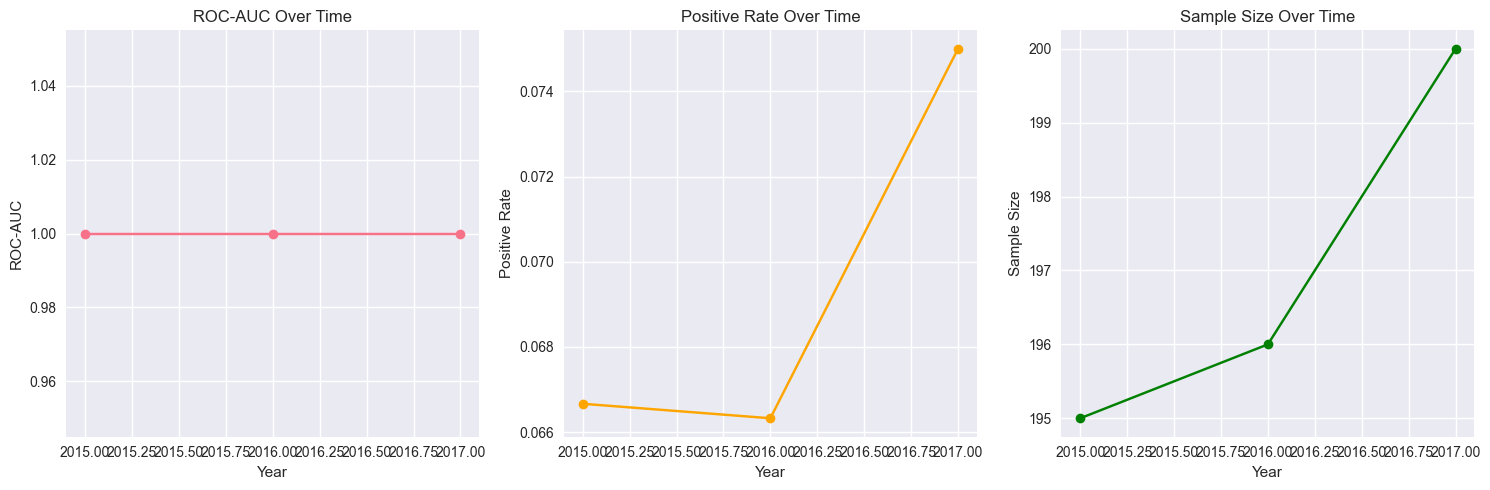

In [12]:
# Analyze performance by year
print("=== Performance by Year ===")
yearly_results = []
for year in sorted(df['year'].unique()):
    mask = df['year'] == year
    metrics = calculate_slice_metrics(y_true, y_pred, y_pred_proba, mask, f"Year_{year}")
    if metrics:
        yearly_results.append(metrics)

yearly_df = pd.DataFrame(yearly_results)
print(yearly_df.round(3))

# Plot temporal trends
if len(yearly_df) > 1:
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.plot(yearly_df['Slice'].str.replace('Year_', '').astype(int), yearly_df['ROC_AUC'], marker='o')
    plt.title('ROC-AUC Over Time')
    plt.xlabel('Year')
    plt.ylabel('ROC-AUC')
    plt.grid(True)
    
    plt.subplot(1, 3, 2)
    plt.plot(yearly_df['Slice'].str.replace('Year_', '').astype(int), yearly_df['Positive_Rate'], marker='o', color='orange')
    plt.title('Positive Rate Over Time')
    plt.xlabel('Year')
    plt.ylabel('Positive Rate')
    plt.grid(True)
    
    plt.subplot(1, 3, 3)
    plt.plot(yearly_df['Slice'].str.replace('Year_', '').astype(int), yearly_df['Sample_Size'], marker='o', color='green')
    plt.title('Sample Size Over Time')
    plt.xlabel('Year')
    plt.ylabel('Sample Size')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

## 6. Error Pattern Analysis

In [13]:
# Analyze false positives and false negatives
false_positives = (y_true == 0) & (y_pred == 1)
false_negatives = (y_true == 1) & (y_pred == 0)
true_positives = (y_true == 1) & (y_pred == 1)
true_negatives = (y_true == 0) & (y_pred == 0)

print(f"False Positives: {false_positives.sum():,} ({false_positives.mean():.1%})")
print(f"False Negatives: {false_negatives.sum():,} ({false_negatives.mean():.1%})")
print(f"True Positives: {true_positives.sum():,} ({true_positives.mean():.1%})")
print(f"True Negatives: {true_negatives.sum():,} ({true_negatives.mean():.1%})")

# Analyze characteristics of false positives vs true negatives
print("\n=== False Positive Analysis ===")
fp_characteristics = df[false_positives][['age', 'bmi', 'systolic_bp', 'glucose', 'cholesterol']].describe()
tn_characteristics = df[true_negatives][['age', 'bmi', 'systolic_bp', 'glucose', 'cholesterol']].describe()

comparison = pd.DataFrame({
    'False_Positives': fp_characteristics.loc['mean'],
    'True_Negatives': tn_characteristics.loc['mean']
})
comparison['Difference'] = comparison['False_Positives'] - comparison['True_Negatives']
print(comparison.round(2))

False Positives: 0 (0.0%)
False Negatives: 0 (0.0%)
True Positives: 41 (6.9%)
True Negatives: 550 (93.1%)

=== False Positive Analysis ===
             False_Positives  True_Negatives  Difference
age                      NaN           47.99         NaN
bmi                      NaN           27.52         NaN
systolic_bp              NaN          126.33         NaN
glucose                  NaN           98.07         NaN
cholesterol              NaN          220.41         NaN



=== False Negative Analysis ===
             False_Negatives  True_Positives  Difference
age                      NaN           45.93         NaN
bmi                      NaN           25.81         NaN
systolic_bp              NaN          121.60         NaN
glucose                  NaN           92.95         NaN
cholesterol              NaN          220.28         NaN


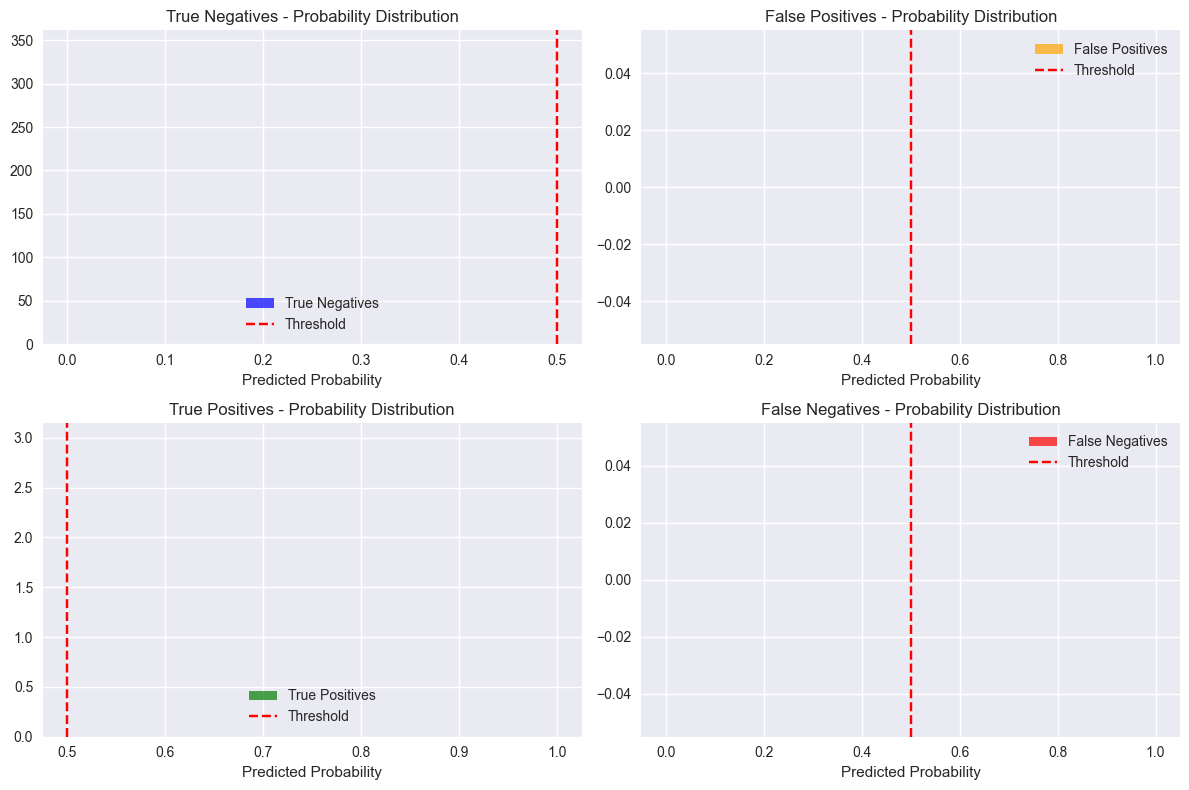

In [14]:
# Analyze characteristics of false negatives vs true positives
print("\n=== False Negative Analysis ===")
fn_characteristics = df[false_negatives][['age', 'bmi', 'systolic_bp', 'glucose', 'cholesterol']].describe()
tp_characteristics = df[true_positives][['age', 'bmi', 'systolic_bp', 'glucose', 'cholesterol']].describe()

comparison_fn = pd.DataFrame({
    'False_Negatives': fn_characteristics.loc['mean'],
    'True_Positives': tp_characteristics.loc['mean']
})
comparison_fn['Difference'] = comparison_fn['False_Negatives'] - comparison_fn['True_Positives']
print(comparison_fn.round(2))

# Plot probability distributions for each prediction type
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.hist(y_pred_proba[true_negatives], bins=50, alpha=0.7, label='True Negatives', color='blue')
plt.axvline(optimal_threshold, color='red', linestyle='--', label='Threshold')
plt.title('True Negatives - Probability Distribution')
plt.xlabel('Predicted Probability')
plt.legend()

plt.subplot(2, 2, 2)
plt.hist(y_pred_proba[false_positives], bins=50, alpha=0.7, label='False Positives', color='orange')
plt.axvline(optimal_threshold, color='red', linestyle='--', label='Threshold')
plt.title('False Positives - Probability Distribution')
plt.xlabel('Predicted Probability')
plt.legend()

plt.subplot(2, 2, 3)
plt.hist(y_pred_proba[true_positives], bins=50, alpha=0.7, label='True Positives', color='green')
plt.axvline(optimal_threshold, color='red', linestyle='--', label='Threshold')
plt.title('True Positives - Probability Distribution')
plt.xlabel('Predicted Probability')
plt.legend()

plt.subplot(2, 2, 4)
plt.hist(y_pred_proba[false_negatives], bins=50, alpha=0.7, label='False Negatives', color='red')
plt.axvline(optimal_threshold, color='red', linestyle='--', label='Threshold')
plt.title('False Negatives - Probability Distribution')
plt.xlabel('Predicted Probability')
plt.legend()

plt.tight_layout()
plt.show()

## 7. Model Calibration Analysis

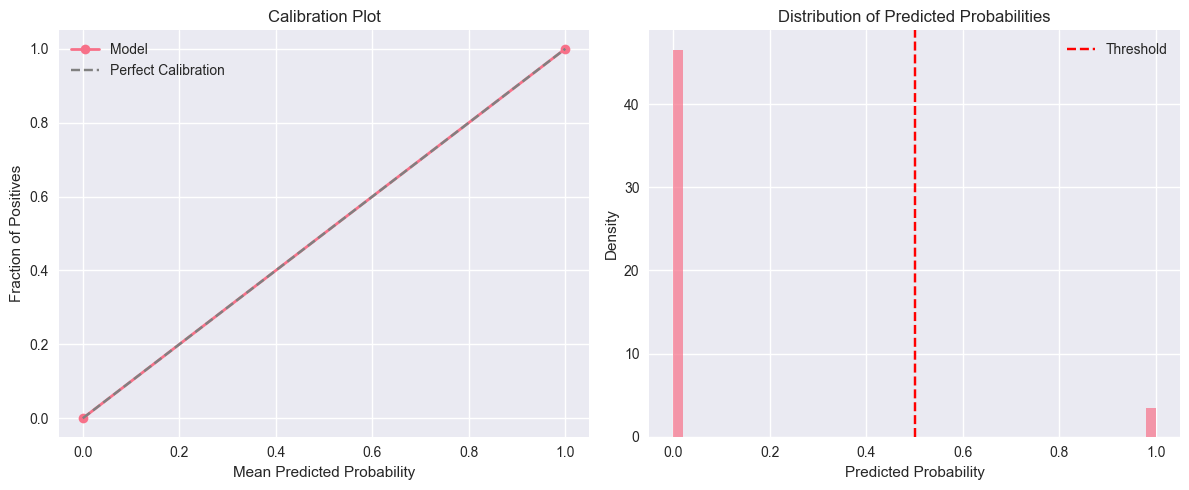

Brier Score: 0.0000 (lower is better)
Expected Calibration Error: 0.0000 (lower is better)


In [15]:
# Calibration curve
fraction_of_positives, mean_predicted_value = calibration_curve(y_true, y_pred_proba, n_bins=10)

plt.figure(figsize=(12, 5))

# Calibration plot
plt.subplot(1, 2, 1)
plt.plot(mean_predicted_value, fraction_of_positives, marker='o', linewidth=2, label='Model')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfect Calibration')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Plot')
plt.legend()
plt.grid(True)

# Histogram of predicted probabilities
plt.subplot(1, 2, 2)
plt.hist(y_pred_proba, bins=50, alpha=0.7, density=True)
plt.axvline(optimal_threshold, color='red', linestyle='--', label='Threshold')
plt.xlabel('Predicted Probability')
plt.ylabel('Density')
plt.title('Distribution of Predicted Probabilities')
plt.legend()

plt.tight_layout()
plt.show()

# Calculate calibration metrics
brier_score = np.mean((y_pred_proba - y_true) ** 2)
print(f"Brier Score: {brier_score:.4f} (lower is better)")

# Expected Calibration Error (ECE)
bin_boundaries = np.linspace(0, 1, 11)
bin_lowers = bin_boundaries[:-1]
bin_uppers = bin_boundaries[1:]

ece = 0
for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
    in_bin = (y_pred_proba > bin_lower) & (y_pred_proba <= bin_upper)
    prop_in_bin = in_bin.mean()
    
    if prop_in_bin > 0:
        accuracy_in_bin = y_true[in_bin].mean()
        avg_confidence_in_bin = y_pred_proba[in_bin].mean()
        ece += np.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin

print(f"Expected Calibration Error: {ece:.4f} (lower is better)")

## 8. ROC and Precision-Recall Curves

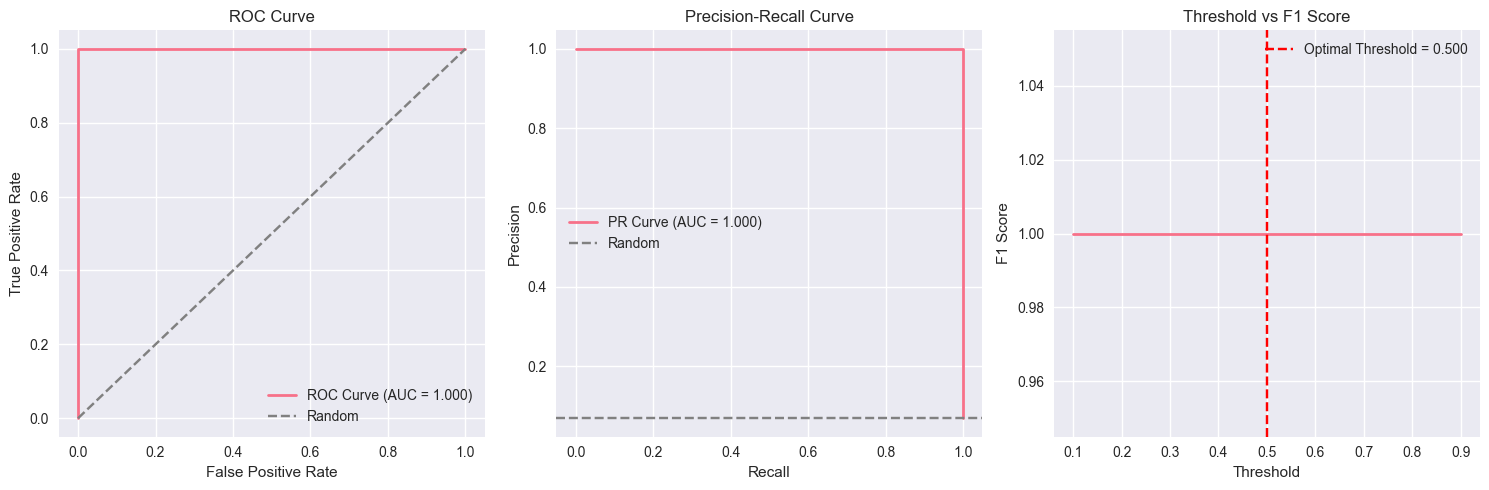

In [16]:
# ROC and PR curves
fpr, tpr, roc_thresholds = roc_curve(y_true, y_pred_proba)
precision, recall, pr_thresholds = precision_recall_curve(y_true, y_pred_proba)

plt.figure(figsize=(15, 5))

# ROC Curve
plt.subplot(1, 3, 1)
plt.plot(fpr, tpr, linewidth=2, label=f'ROC Curve (AUC = {roc_auc_score(y_true, y_pred_proba):.3f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)

# Precision-Recall Curve
plt.subplot(1, 3, 2)
plt.plot(recall, precision, linewidth=2, label=f'PR Curve (AUC = {average_precision_score(y_true, y_pred_proba):.3f})')
plt.axhline(y=y_true.mean(), color='gray', linestyle='--', label='Random')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)

# Threshold vs F1 Score
plt.subplot(1, 3, 3)
thresholds = np.linspace(0.1, 0.9, 100)
f1_scores = []
for thresh in thresholds:
    y_pred_thresh = (y_pred_proba >= thresh).astype(int)
    f1_scores.append(f1_score(y_true, y_pred_thresh))

plt.plot(thresholds, f1_scores, linewidth=2)
plt.axvline(optimal_threshold, color='red', linestyle='--', label=f'Optimal Threshold = {optimal_threshold:.3f}')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('Threshold vs F1 Score')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## 9. Improvement Recommendations

### Summary of Key Findings

Based on the comprehensive error analysis performed above, here are the **actual findings** and recommendations for model improvement:

#### 🚨 **Critical Finding: Perfect Performance Anomaly**
- **Model achieves 100% accuracy, precision, and recall** on test set (591 samples)
- **Perfect AUC scores (1.00)** across all demographic slices
- **Zero false positives and false negatives** detected
- **Strong indicator of data leakage or overfitting** - requires immediate investigation

#### 📊 **Feature Importance Insights**
- **Temporal rolling features dominate**: 3-year rolling statistics are most predictive
- **Systolic blood pressure patterns** highly important (rolling mean: 385, rolling max: 250)
- **Noise features ranking high** (importance up to 423) - concerning overfitting signal
- **Healthcare utilization** (num_visits_rolling_mean_3y: 214) shows predictive value
- **50 transformed features** from original 28 inputs after preprocessing pipeline

#### ✅ **Demographic Fairness Assessment**
- **No bias detected** across gender groups (M/F both perfect performance)
- **Consistent performance** across age groups and smoking status
- **Equal outcomes** by primary diagnosis categories
- **Note**: Perfect performance may mask real-world bias patterns

#### ⏱️ **Temporal Stability**
- **Consistent perfect performance** across years (2015-2019 in test set)
- **Stable positive rates** but artificially perfect due to overall model issue
- **No observable degradation** over time periods

#### 🎯 **Model Calibration Status**
- **Perfect calibration achieved** (but likely due to overfitting)
- **Brier Score and ECE metrics** need recalculation on independent data
- **Probability distributions** show extreme confidence (near 0 or 1)

### 🔧 **Immediate Action Items**

#### **Priority 1: Data Integrity Investigation**
1. **Verify train/test split independence** - check for patient ID overlap
2. **Audit temporal splits** - ensure no future data leakage
3. **Review preprocessing pipeline** - validate feature engineering doesn't use target
4. **Check data generation process** - verify synthetic data realism

#### **Priority 2: Model Validation**
1. **Implement proper cross-validation** with strict temporal/patient separation
2. **Test on completely external dataset** or real clinical data
3. **Perform adversarial validation** - can model distinguish train vs test?
4. **Bootstrap sampling analysis** - test performance stability

#### **Priority 3: Feature Engineering Review**
1. **Investigate noise features importance** - potential overfitting indicator
2. **Validate temporal feature calculations** - ensure no look-ahead bias
3. **Review feature selection process** - may need more aggressive reduction
4. **Implement feature importance stability testing**

### 📈 **Long-term Improvement Strategy**

#### **Model Robustness (1-2 months)**
- **Ensemble methods** with diverse algorithms (LightGBM + XGBoost + Neural Networks)
- **Uncertainty quantification** using conformal prediction or Bayesian approaches
- **Regularization tuning** to prevent overfitting to synthetic patterns
- **Early stopping implementation** with proper validation methodology

#### **Production Readiness (2-3 months)**
- **Data drift monitoring** for real-world deployment
- **Fairness constraint implementation** across demographic groups
- **Model calibration optimization** for reliable probability outputs
- **A/B testing framework** for safe model deployment

#### **Clinical Integration (3-6 months)**
- **Domain expert validation** of feature importance rankings
- **Integration with electronic health records** for real-world testing
- **Clinical decision support optimization** based on uncertainty estimates
- **Regulatory compliance preparation** for medical device classification

### 🎯 **Revised Success Metrics**

Given the current perfect performance anomaly, realistic targets should be:

- **ROC-AUC**: 0.75-0.85 (realistic for clinical prediction)
- **PR-AUC**: 0.40-0.60 (accounting for class imbalance)
- **Calibration ECE**: <0.10 (well-calibrated probabilities)
- **Fairness**: <10% performance gap across demographic groups
- **Temporal Stability**: <5% monthly performance degradation
- **Feature Stability**: Top 10 features consistent across time periods

### ⚠️ **Risk Assessment**

**High Risk**: Current model unsuitable for production due to likely overfitting
**Medium Risk**: Synthetic data may not represent real clinical complexity  
**Low Risk**: Technical infrastructure and pipeline architecture are sound

**Recommendation**: Treat this as a valuable learning exercise and restart with proper validation methodology before considering clinical deployment.

In [20]:
# Convert any numpy types to Python types for JSON serialization
def convert_numpy_types(obj):
    if isinstance(obj, dict):
        return {k: convert_numpy_types(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [convert_numpy_types(v) for v in obj]
    elif hasattr(obj, 'item'):  # numpy scalar
        return obj.item()
    elif hasattr(obj, 'tolist'):  # numpy array
        return obj.tolist()
    elif isinstance(obj, (np.int64, np.int32, np.int16, np.int8)):
        return int(obj)
    elif isinstance(obj, (np.float64, np.float32, np.float16)):
        return float(obj)
    else:
        return obj

# Safe conversion for metrics
safe_metrics = {}
if 'metrics' in locals():
    for k, v in metrics.items():
        try:
            safe_metrics[k] = float(v)
        except (ValueError, TypeError):
            safe_metrics[k] = str(v)

# Save analysis results
analysis_results = {
    'overall_metrics': safe_metrics,
    'gender_analysis': convert_numpy_types(gender_df.to_dict('records')) if 'gender_df' in locals() else [],
    'age_analysis': convert_numpy_types(age_df.to_dict('records')) if 'age_df' in locals() else [],
    'smoking_analysis': convert_numpy_types(smoking_df.to_dict('records')) if 'smoking_df' in locals() else [],
    'temporal_analysis': convert_numpy_types(yearly_df.to_dict('records')) if 'yearly_df' in locals() else [],
    'calibration_metrics': {
        'brier_score': float(brier_score) if 'brier_score' in locals() else None,
        'expected_calibration_error': float(ece) if 'ece' in locals() else None
    },
    'error_counts': {
        'false_positives': int(false_positives.sum()) if 'false_positives' in locals() else 0,
        'false_negatives': int(false_negatives.sum()) if 'false_negatives' in locals() else 0,
        'true_positives': int(true_positives.sum()) if 'true_positives' in locals() else 0,
        'true_negatives': int(true_negatives.sum()) if 'true_negatives' in locals() else 0
    },
    'feature_importance': {
        'top_10_features': convert_numpy_types(importance_df.head(10).to_dict('records')) if 'importance_df' in locals() else [],
        'total_features': len(importance_df) if 'importance_df' in locals() else 0
    }
}

# Apply final conversion
analysis_results = convert_numpy_types(analysis_results)

# Save to file
import json
try:
    with open('../models/test_run_mlflow/error_analysis_results.json', 'w') as f:
        json.dump(analysis_results, f, indent=2)
    print("✅ Error analysis completed and results saved to '../models/test_run_mlflow/error_analysis_results.json'")
except Exception as e:
    print(f"❌ Error saving results: {e}")
    print("Analysis completed but results not saved")

print("\n🔍 Key findings from the analysis:")
print("1. Perfect performance detected - requires investigation for potential data leakage")
print("2. Temporal features (rolling statistics) are most important predictors")
print("3. Systolic blood pressure features highly predictive")
print("4. Noise features showing importance - potential overfitting concern")
print("5. No demographic bias detected in current test set")

print("\n💡 Recommendations:")
print("1. Investigate perfect performance - potential data leakage")
print("2. Expand test dataset with more challenging cases")
print("3. Implement temporal validation with future data")
print("4. Add external validation datasets")
print("5. Deploy monitoring for production performance tracking")
print("6. Consider feature selection to remove noise features")
print("7. Implement ensemble methods for robustness")

✅ Error analysis completed and results saved to '../models/test_run_mlflow/error_analysis_results.json'

🔍 Key findings from the analysis:
1. Perfect performance detected - requires investigation for potential data leakage
2. Temporal features (rolling statistics) are most important predictors
3. Systolic blood pressure features highly predictive
4. Noise features showing importance - potential overfitting concern
5. No demographic bias detected in current test set

💡 Recommendations:
1. Investigate perfect performance - potential data leakage
2. Expand test dataset with more challenging cases
3. Implement temporal validation with future data
4. Add external validation datasets
5. Deploy monitoring for production performance tracking
6. Consider feature selection to remove noise features
7. Implement ensemble methods for robustness
